In [ ]:
pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import os
import gc
import random
import matplotlib.pyplot as plt
import zipfile
import keras
from sklearn.model_selection import train_test_split
from keras import layers
from keras import ops
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError, RootMeanSquaredError
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
from tensorflow.keras.callbacks import Callback, CSVLogger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
data_path = '/content/drive/MyDrive/GalaxyZoo/compressed_img_target.npz'
loaded_arrays = np.load(data_path)

with tqdm(total=1) as pbar:
    training_images = np.load(data_path, allow_pickle=True)  # allow_pickle=True is necessary for loading npz files with Python 3.7+
    pbar.update(1) # Update progress bar

# Retrieve the arrays
train = loaded_arrays['images']
target = loaded_arrays['target']

print("Shape of the array of training images:", train.shape)

100%|██████████| 1/1 [00:00<00:00, 118.14it/s]


Shape of the array of training images: (61578, 64, 64, 3)


In [ ]:
# First split to separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

# Normalize pixel values to range [0, 1]
X_temp = X_temp.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_temp = y_temp.astype('float32')
y_test = y_test.astype('float32')

# Second split to divide the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Image augmentation

In [ ]:
# Initialising the ImageDataGenerator with specified augmentations
training_data_generator = ImageDataGenerator(
    zoom_range=0.10,  # Randomly increase or decrease the size of the image by up to 10%
    rotation_range=25,  # Randomly rotate the image between -25 to 25 degrees
    width_shift_range=0.05,  # Shift the image along its width by up to +/- 5%
    height_shift_range=0.05,  # Shift the image along its height by up to +/- 5%
    fill_mode='nearest',  # Fill in newly created pixels after a shift or rotation
)

# Creating a generator that will be used for training
train_generator = training_data_generator.flow(
    X_train, y_train,
    batch_size=128
)

# Constrained loss function

In [ ]:
def custom_loss(y_true, y_pred):
    lamda = 0.001
    c1 = tf.abs(tf.reduce_sum(y_pred[:, 0:3], axis=1) - 1) # Class 1 constraint
    c2 = tf.abs(tf.reduce_sum(y_pred[:, 13:15], axis=1) - 1) # Class 6 constraint
    c3 = tf.abs((y_pred[:, 3] + y_pred[:, 4]) - y_pred[:, 1]) # Class 2 constraint
    c4 = tf.abs((y_pred[:, 15] + y_pred[:, 16] + y_pred[:, 17]) - y_pred[:, 10]) # Class 7 constraint
    c5 = tf.abs(tf.reduce_sum(y_pred[:, 18:25], axis=1) - y_pred[:, 13]) # Class 8 constraint
    c6 = tf.abs(tf.reduce_sum(y_pred[:, 25:28], axis=1) - y_pred[:, 3]) # Class 9 constraint
    c7 = tf.abs(tf.reduce_sum(y_pred[:, 5:7], axis=1) - y_pred[:, 4]) # Class 3 constraint
    c8 = tf.abs(tf.reduce_sum(y_pred[:, 7:9], axis=1) - y_pred[:, 4]) # Class 4 constraint
    c9 = tf.abs(tf.reduce_sum(y_pred[:, 28:31], axis=1) - y_pred[:, 7]) # Class 10 constraint
    c10 = tf.abs(tf.reduce_sum(y_pred[:, 9:13], axis=1) - y_pred[:, 7] - y_pred[:, 8]) # Class 5 constraint
    c11 = tf.abs(tf.reduce_sum(y_pred[:, 31:37], axis=1) - y_pred[:, 7]) # Class 11 constraint

    c_loss = lamda*(c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+c11)

    # Base loss (mean squared error)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Combine base loss with constraints
    return mse_loss + c_loss

# Vision Transformer

## Configure hyperparameters for ViT architecture

In [ ]:
batch_size = 128
image_size = 64  # Keep image size to 64x64
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64 # Size of embedding vector
num_heads = 8 # Number of attention heads per transformer
transformer_units = [projection_dim * 2, projection_dim,]  # Size of the MLP in transformer
transformer_layers = 12 # Number of tansformer layers in ViT
mlp_head_units = [64, 64,]  # Size of the dense layers of the final classifier

## Implement MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

## Example of image as patches

Image size: 64 X 64
Patch size: 8 X 8
Patches per image: 64
Elements per patch: 192


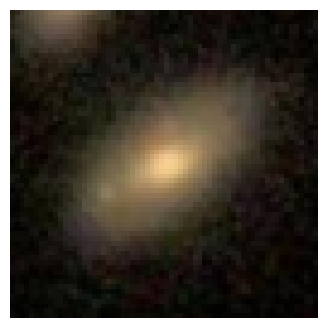

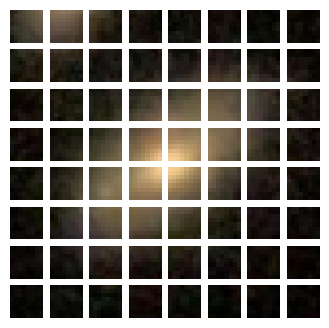

In [ ]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img))
    plt.axis("off")

## Implement the patch encoding layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.projection_dim = projection_dim
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1, output_dim=projection_dim
        )

    def call(self, patch):
        batch_size = tf.shape(patch)[0]
        cls_token = tf.zeros((batch_size, 1, self.projection_dim))
        patch = tf.concat([cls_token, self.projection(patch)], axis=1) # Add learnable classifier token
        positions = tf.range(start=0, limit=self.num_patches, dtype=tf.int32)
        positions = self.position_embedding(positions) # Add learnable positioning embedding
        encoded = patch + positions
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection_dim})
        return config

## Build ViT model

In [ ]:
def build_vit():
    inputs = keras.Input(shape=(64, 64, 3))
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches + 1, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Take classification token from output of final transformer layer as representation
    representation = encoded_patches[:, 0, :]
    representation = layers.LayerNormalization(epsilon=1e-6)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    # Classify outputs
    vec = layers.Dense(37, activation='sigmoid')(features)
    # Create model
    model = keras.Model(inputs=inputs, outputs=vec)
    return model

In [ ]:
vit = build_vit()
vit.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_1 (Patches)       │ (None, 64, 192)        │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 65, 64)         │         16,576 │ patches_1[0][0]        │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 65, 64)         │            128 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 65, 64)         │        132,672 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 65, 64)         │              0 │ multi_head_attention[… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 65, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 65, 128)        │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 65, 128)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 65, 64)         │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 65, 64)         │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 65, 64)         │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 65, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 65, 64)         │        132,672 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 65, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├──────────────────────

 Total params: 1,821,477 (6.95 MB)

 Trainable params: 1,821,477 (6.95 MB)

 Non-trainable params: 0 (0.00 B)

## Save weights and training history

In [ ]:
# Directory where checkpoints and history will be saved
checkpoint_dir = '/content/drive/MyDrive/GalaxyZoo/vitb16_checkpoints/'
history_file = '/content/drive/MyDrive/GalaxyZoo/vitb16_training_history.csv'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Callback for model checkpoints
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'vitb16_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.keras'),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Callback for saving training history
csv_logger = CSVLogger(history_file, append=True)

In [ ]:
# EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)

In [ ]:
# Compile model
vit.compile(optimizer='adam',
            loss = custom_loss,
            metrics=[RootMeanSquaredError()])

## Train model

In [ ]:
history = vit.fit(train_generator, validation_data=(X_val, y_val), epochs=300, callbacks=[checkpoint_callback, csv_logger, early_stopping_callback])

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.0838 - root_mean_squared_error: 0.2751
Epoch 1: val_loss improved from inf to 0.02777, saving model to /content/drive/MyDrive/GalaxyZoo/vitb16_checkpoints/vitb16_epoch_01_val_loss_0.03.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 314s 542ms/step - loss: 0.0837 - root_mean_squared_error: 0.2749 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1652
Epoch 2/300
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0302 - root_mean_squared_error: 0.1713
Epoch 2: val_loss improved from 0.02777 to 0.02407, saving model to /content/drive/MyDrive/GalaxyZoo/vitb16_checkpoints/vitb16_epoch_02_val_loss_0.02.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - loss: 0.0302 - root_mean_squared_error: 0.1712 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1531
Epoch 3/300
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0260 - root_mean_squared_error: 0.1586
Epoch 3: val_loss improved from 0.02407 to 0.02326, saving model to /content/drive/MyDrive/

# Training and validation history

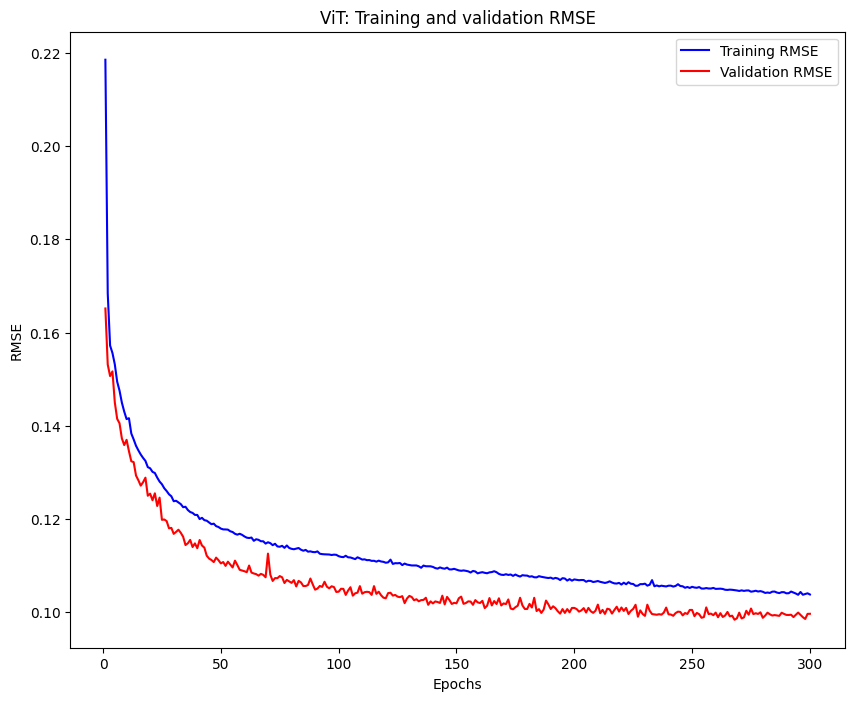

In [ ]:
history_file_path = '/content/drive/MyDrive/GalaxyZoo/vitb16_training_history.csv'
training_history = pd.read_csv(history_file_path)

train_metric = training_history['root_mean_squared_error']
val_metric = training_history['val_root_mean_squared_error']
epochs = range(1, len(train_metric) + 1)

plt.figure(figsize=(10, 8))
plt.plot(epochs, train_metric, 'b', label='Training RMSE')
plt.plot(epochs, val_metric, 'r', label='Validation RMSE')
plt.title('ViT: Training and validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('/content/drive/MyDrive/GalaxyZoo/Plots/vitb16_trainval.png')
plt.show()

# Out of sample performance

In [ ]:
# Build latest model from saved weights
vit = build_vit()
vit.load_weights('/content/drive/MyDrive/GalaxyZoo/vitb16_checkpoints/vitb16_epoch_268_val_loss_0.01.keras')

vit.compile(optimizer='adam',
            loss = custom_loss,
            metrics=[RootMeanSquaredError()])

In [ ]:
# Evaluate model
test_loss, test_rmse = vit.evaluate(X_test, y_test)
print('Test RMSE:', test_rmse)

385/385 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0104 - root_mean_squared_error: 0.0996
Test RMSE: 0.09950700402259827


# Code to resume training from saved checkpoint if runtime disconnects

In [ ]:
def load_latest_checkpoint(model, checkpoint_dir):
    list_of_files = glob.glob(checkpoint_dir + '/*.keras')
    if not list_of_files:  # No checkpoints exist
        return model  # Return the original model if no checkpoints found
    latest_file = max(list_of_files, key=os.path.getctime)  # Find the latest checkpoint
    print(f"Loading weights from {latest_file}")
    model = model.load_weights(latest_file)
    return model

# Assuming `model` is your model instance
vit = load_latest_checkpoint(vit, checkpoint_dir)

In [ ]:
def get_initial_epoch_from_history(history_file):
    try:
        # Load the training history CSV file
        history_df = pd.read_csv(history_file)
        # The initial epoch should be one more than the last epoch in the history
        initial_epoch = history_df.epoch.max() + 1
        print(f"Resuming training from epoch {initial_epoch}")
    except Exception as e:
        print(f"Could not load history from {history_file}. Starting from scratch. Error: {e}")
        initial_epoch = 0
    return initial_epoch

# Get the initial_epoch value
initial_epoch = get_initial_epoch_from_history(history_file)

In [ ]:
vit.compile(optimizer='adam',
            loss = custom_loss,
            metrics=[RootMeanSquaredError()])

In [ ]:
history = vit.fit(train_generator, validation_data=(X_val, y_val), epochs=300,
                  callbacks=[checkpoint_callback, csv_logger, early_stopping_callback],
                  initial_epoch = initial_epoch)